<a href="https://colab.research.google.com/github/LingFengZhang24/Code4Paper_Unsupervised_Learning_of_Non_Hermitian_Topological_Phases/blob/main/Code4Paper%22Unsupervised_Learning_of_Non_Hermitian_Topological_Phases%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

# Diffusion map


In [5]:
def diffusion_mat(datas, gaussian_kfunc):
    """
    Parameters
    ----------
    datas : ndarray
        n samples with m features should have shape [n,m].
    gaussian_kfunc: callable function
        gaussian kernel function.
    Returns
    -------
    ndarray
        one-step difussion matrix.
    """

    df_mat = np.zeros((datas.shape[0],datas.shape[0]))
    for i in range(datas.shape[0]):
        for j in range(i+1,datas.shape[0]):
            df_mat[i,j] = gaussian_kfunc(datas[i], datas[j])
    df_mat = df_mat+ df_mat.T + np.eye(datas.shape[0],datas.shape[0])
    return df_mat

class GaussianKernel:
    def __init__(self, N, epsilon, norm="L1"):
        self.N = N
        self.epsilon = epsilon
        self.norm = norm
    
    def __call__(self, x1, x2):
        if self.norm == "L1":
            return np.exp(-np.sum(np.abs(x1-x2))**2/(2*self.epsilon*self.N**2))
        elif self.norm == "L2":
            return np.exp(-np.abs(x1-x2)**2/(2*self.epsilon*self.N**2))
        else:
            raise Exception("undefine nrom type")


# Unsupervised learning without NHSE

a general two-band model with PBC in the momenrum space: $\hat{H}=\mathbf{d}\vec{\sigma}=d_x \sigma_x + d_y \sigma_y + d_z \sigma_z$

input data sample to be $x^{(l)}=\{\hat{\mathbf{d}}^{(l)}(\vec{k})|\vec{k}\in BZ\}$ 

where $\hat{\mathbf{d}}=\frac{\mathbf{d}}{\sqrt{d_{x}^2+d_{y}^2+d_{z}^2}}$ and BZ denoting the first brillouin zone.

## non-Hermitian SSH model with PBC

$H_p(k)=\vec{\mathbf{d}}\cdot\vec{\sigma}=d_x\sigma_x + d_y \sigma_y$

where $d_x=t_1 +t_2 \cos{k}$, $d_y = t_2 \sin{k} + i\gamma$.

input data set are chosen as $\{x^{(l)}|x^{(l)}=\{\hat{\mathbf{d}}(k_i),|k_i=\frac{2i-N-2}{N}\pi, i\in[1,N] \}\}$ with varying $t_1$, while fixing $t_2$ and $\gamma$.

Winding number $W=\frac{1}{2\pi}\int^{\pi}_{-\pi}\frac{d_x\partial_k d_y - d_y \partial_k d_x }{d_x^2 + d_y^2}dk$

Following the Ref.1.SM, choose $N=160, t_2=1,\gamma=0.3,t_1\in[0,3.0695]$, sample interval $\delta t_1=\frac{1}{\pi^4}$, $\epsilon=0.001$

In [3]:
class NH_SSH_Momentum:
    def data_sample(self, t1, t2, gamma, N):
        """
        Parameters
        ----------
        t1 : float
            intracell hopping strength.
        t2 : float
            intercell hopping strength.
        gamma : float
            nonreciprocal term.
        N : int
            number of unit cell.

        Returns
        -------
        ndarray 
            Hamiltonian features in momentum space with a shape of [N,2].

        """
        k_lst = ((2*np.arange(1,N+1))-N-2)/N *np.pi
        self.d_x = t1 + t2*np.cos(k_lst) 
        self.d_y = t2*np.sin(k_lst) + 1j * gamma
        abs_val = np.sqrt(self.d_x**2 + self.d_y**2)
        self.d_x = self.d_x / abs_val
        self.d_y = self.d_y / abs_val
        return np.concatenate((self.d_x[:,np.newaxis],self.d_y[:,np.newaxis]),axis=1)
        
    def topo_invariant(self):
        delta_k_dx = np.diff(self.d_x)
        delta_k_dx = np.append(delta_k_dx, self.d_x[-1]-self.d_x[0])
        delta_k_dy = np.diff(self.d_y)
        delta_k_dy = np.append(delta_k_dy,self.d_y[-1]-self.d_y[0])
        w = np.real(np.sum(self.d_x*delta_k_dy - self.d_y*delta_k_dx)/2/np.pi)
        return w
    
    def __call__(self, t1, t2, gamma, N):
        x = self.data_sample(t1, t2, gamma, N)
        y = self.topo_invariant()
        return x,y

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


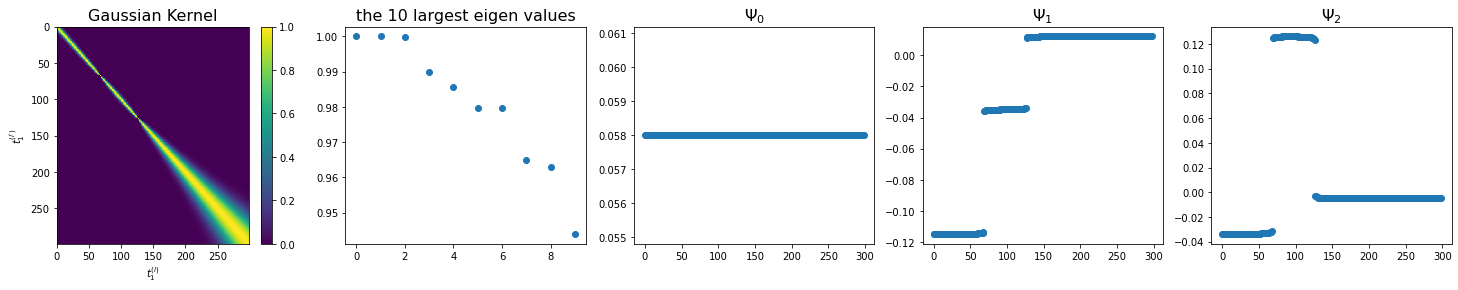

In [4]:
t1 = 0.9
t2 = 1
N = 160
gamma = 0.3
epsilon = 0.001
t1_lst = np.arange(0,3.0695,1/np.pi**4)
nh_ssh_momen = NH_SSH_Momentum()   
xs = np.zeros((len(t1_lst),N,2),dtype=complex)
ys = np.zeros((len(t1_lst),1))
for ith, t1 in enumerate(t1_lst):
    xs[ith],ys[ith] = nh_ssh_momen(t1, t2, gamma, N)
kfunc = GaussianKernel(N,epsilon)
df_mat = diffusion_mat(xs, kfunc)

df_prob = df_mat / np.sum(df_mat,axis=1)[:,np.newaxis]
evals, evs = la.eig(df_prob)
sorted_index = np.argsort(np.real(evals))[::-1]
evs = evs[:,sorted_index]
evals = evals[sorted_index]
fig = plt.figure(figsize=(25,4))

ax1 = fig.add_subplot(151)
ax1.set_title("Gaussian Kernel", fontsize=16)
c = ax1.pcolormesh(df_mat)
ax1.invert_yaxis()
plt.colorbar(c)
ax1.set_xlabel("$t_1^{(l)}$")
ax1.set_ylabel("$t_1^{(l^{'})}$")
ax2 = fig.add_subplot(152)
ax2.scatter(np.arange(10), evals[:10])
ax2.set_title("the 10 largest eigen values",fontsize=16)
ax3 = fig.add_subplot(153)
ax3.scatter(np.arange(len(t1_lst)), np.round(evs[:,0],3))
ax3.set_title("$\Psi_0$",fontsize=16)
ax4 = fig.add_subplot(154)
ax4.scatter(np.arange(len(t1_lst)), evs[:,1])
ax4.set_title("$\Psi_1$",fontsize=16)
ax5 = fig.add_subplot(155)
ax5.scatter(np.arange(len(t1_lst)), evs[:,2])
ax5.set_title("$\Psi_2$",fontsize=16)
plt.show()

# Unsupervised learning with NHSE

We need to choose different input data because the presence of NHSE may handicap the performance of diffusion map.

projective matrices:$P=\sum_{\Re[{E_m}]<0}\left|m_R\right\rangle\left\langle m_L\right|$


data sample: partial elements of the projective matrices $\{P^{(l)}_{iA,iB}|i\in[1,N]\}$ 

### non-Hermitian SSH with OBC
1D nh ssh model:
$\mathcal{H} = \sum_i(t_1+\gamma)\hat{c}^{\dagger}_{i,A}\hat{c}_{i,B}+(t_1-\gamma)\hat{c}^{\dagger}_{i,B}\hat{c}_{i,A}+t_2\hat{c}^{\dagger}_{i,B}\hat{c}_{i+1,A}+t_2\hat{c}^{\dagger}_{i+1,A}\hat{c}_{i,B}$

with a matrix form e.g. for 2 sites
$H = \begin{pmatrix}
0 & t_1+\gamma & 0 & 0 \\
t_1-\gamma & 0 & t_2& 0 \\
0 & t_2 & 0  & t_1+\gamma \\
0 & 0& t_1-\gamma& 0
\end{pmatrix}$

Winding number:


Following Ref.2, phase boundaries are theoretically predicted to be $t_1=\pm\sqrt{t_2^2+\gamma^2}$

Following Ref.1.SM, number of unit cells $N=80,\epsilon=1\times 10^{-6},t_2=0.6,\gamma=0.4,t_1\in[0,1.6306)$, samples interval $\delta t_1=\frac{1}{\pi^5}$